In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import sys
from   scipy.signal import butter, filtfilt
from   PanTompkins import Pan_Tompkins
from   QRS_detection import Find_R_peaks
from   preprocessing import ButterworthFilters, PPGdenoising
from   Feature_Extraction import PPG_Points, BCG_Waves, BP_Points

In [2]:
data1 = pd.read_csv("C:/Users/eozka/Desktop/ETH/ptt_dataset/gt02.csv")
data1.head()

,finapres BP,finapres systolic,finapres diastolic,biopac BCG,biopac PPG,head forehead IMU Z,head forehead IMU Y,head forehead IMU X,head forehead PPG IR,head forehead PPG R,head forehead PPG G,chest sternum ECG,session
0,128.98650,166.6616,101.6877,5.715942,-0.735474,0.525222,-0.029382,0.843708,0.199881,0.258472,0.400569,0.002390,0
1,128.97734,166.6616,101.6877,5.545960,-0.734558,0.525058,-0.029677,0.843775,0.199884,0.258475,0.400572,0.002333,0
2,128.96818,166.6616,101.6877,5.793762,-0.735779,0.524894,-0.029972,0.843841,0.199889,0.258477,0.400575,0.002275,0
3,128.95902,166.6616,101.6877,5.536804,-0.734863,0.524729,-0.030267,0.843908,0.199893,0.258480,0.400578,0.002218,0
4,128.94986,166.6616,101.6877,5.873718,-0.735474,0.524565,-0.030562,0.843974,0.199897,0.258483,0.400580,0.002161,0


In [3]:
print(data1.columns)

Index(['finapres BP', 'finapres systolic', 'finapres diastolic', 'biopac BCG',
       'biopac PPG', 'head forehead IMU Z', 'head forehead IMU Y',
       'head forehead IMU X', 'head forehead PPG IR', 'head forehead PPG R',
       'head forehead PPG G', 'chest sternum ECG', 'session'],
      dtype='object')


In [4]:
actions = {
    0: "rest initial",
    1: "Sustained grip challenge stand",
    2: "rest after grip",
    3: "Mental AR stand",
    4: "rest after mental",
    5: "Cold Pressor stand",
    6: "rest after cold pres",
    7: "Valsalva Maneuver stand",
    8: "rest after Valsalva",
    9: "Exercise",
    10: "rest after exert"
}

In [5]:
session_dfs = {}

# Group the DataFrame by 'session'
grouped = data1.groupby('session')

# Iterate over each group and store it in the dictionary
for session, group in grouped:
    session_dfs[session] = group


In [6]:
session_val = 0
# Extract Data
BP          = session_dfs[session_val]["finapres BP"]
systolic    = session_dfs[session_val]["finapres systolic"]
diastolic   = session_dfs[session_val]["finapres diastolic"]
finger_PPG  = session_dfs[session_val]["biopac PPG"]
acc_x       = session_dfs[session_val]["head forehead IMU X"]
acc_y       = session_dfs[session_val]["head forehead IMU Y"]
acc_z       = session_dfs[session_val]["head forehead IMU Z"]
head_PPG_IR = session_dfs[session_val]["head forehead PPG IR"]
head_PPG_R  = session_dfs[session_val]["head forehead PPG R"]
BCG         = session_dfs[session_val]["biopac BCG"]
ECG         = session_dfs[session_val]["chest sternum ECG"]

# Sampling frequency
fs = 2000



In [7]:
filters = ButterworthFilters(fs)
# Preprocessing

# Apply high-pass filter to remove low-frequency effects
highpass_filtered_signal = filters.highpass_filter(BCG)

# Apply low-pass filter to remove high-frequency noise
BCG = filters.lowpass_filter(highpass_filtered_signal)
BCG = pd.Series(BCG)


# Apply high-pass filter to remove low-frequency effects
highpass_filtered_signal = filters.highpass_filter(acc_x,0.5,4)

# Apply low-pass filter to remove high-frequency noise
acc_x = filters.lowpass_filter(highpass_filtered_signal,3,4)

# Apply high-pass filter to remove low-frequency effects
highpass_filtered_signal = filters.highpass_filter(acc_y,0.5,4)

# Apply low-pass filter to remove high-frequency noise
acc_y = filters.lowpass_filter(highpass_filtered_signal,3,4)

# Apply high-pass filter to remove low-frequency effects
highpass_filtered_signal = filters.highpass_filter(acc_z,0.5,4)

# Apply low-pass filter to remove high-frequency noise
acc_z = filters.lowpass_filter(highpass_filtered_signal,3,4)

# Preprocessing PPG
dn = PPGdenoising(finger_PPG,10,1500)
[PPG3,PPG4,PPG5] = dn.PPG_median_filter()
PPG5 = pd.Series(PPG5)

# # Apply high-pass filter to remove low-frequency effects
# highpass_filtered_signal = filters.highpass_filter(finger_PPG)

# # Apply low-pass filter to remove high-frequency noise
# PPG5 = filters.lowpass_filter(highpass_filtered_signal)
# PPG5 = pd.Series(BCG)


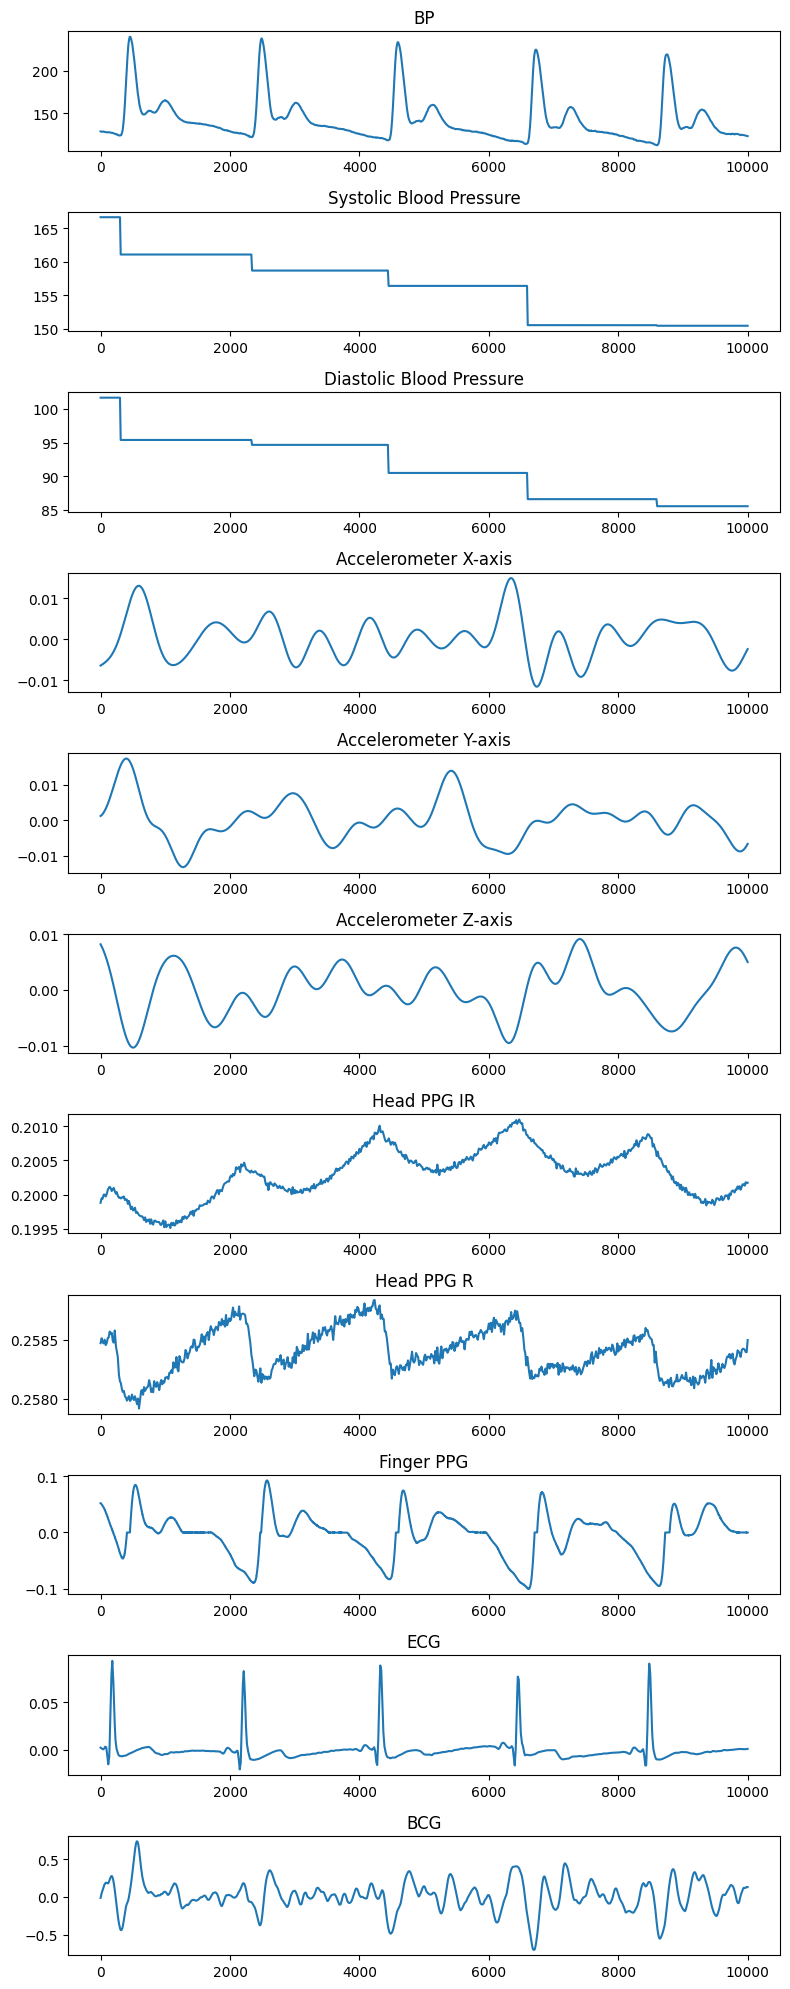

In [8]:
fig, axs = plt.subplots(11, 1, figsize=(8, 20))
end_val    = 10000

# Plot BP
axs[0].plot(BP[:end_val])
axs[0].set_title('BP')

# Plot systolic and diastolic blood pressure
axs[1].plot(systolic[:end_val])
axs[1].set_title('Systolic Blood Pressure')
axs[2].plot(diastolic[:end_val])
axs[2].set_title('Diastolic Blood Pressure')

# Plot accelerometer data
axs[3].plot(acc_x[:end_val])
axs[3].set_title('Accelerometer X-axis')
axs[4].plot(acc_y[:end_val])
axs[4].set_title('Accelerometer Y-axis')
axs[5].plot(acc_z[:end_val])
axs[5].set_title('Accelerometer Z-axis')

# Plot head PPG signals
axs[6].plot(head_PPG_IR[:end_val])
axs[6].set_title('Head PPG IR')
axs[7].plot(head_PPG_R[:end_val])
axs[7].set_title('Head PPG R')

# Plot ECG
axs[9].plot(ECG[:end_val])
axs[9].set_title('ECG')

# Plot finger PPG
axs[8].plot(PPG5[0:end_val])
axs[8].set_title('Finger PPG')

# Plot BCG
axs[10].plot(BCG[:end_val])
axs[10].set_title('BCG')

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
# import pandas as pd   
# data_by_session = {}

# # Group the dataframe by the 'session' column
# grouped     = data1.groupby('session')

# # Iterate over each group and store ECG and BP data in the dictionary
# for session, group in grouped:
#     data_by_session[session] = {'chest sternum ECG': group['chest sternum ECG'].values, 'finapres BP': group['finapres BP'].values}

# ecg_data    = data_by_session[5]['chest sternum ECG']
# bp_data     = data_by_session[0]['finapres BP']




In [10]:
ecg_signal          = ECG.values
first_idx        = ECG.index[0]

QRS = Pan_Tompkins()

lowpass_signal      = QRS.lp_filter(ecg_signal)
bandpass_signal     = QRS.hp_filter(lowpass_signal)
derivative          = QRS.derivative_operator(bandpass_signal,2000)
squared_signal      = QRS.Square(derivative)
integrated_signal   = QRS.moving_window_integration(squared_signal)

peak_detector       = Find_R_peaks(ecg_signal,integrated_signal,bandpass_signal,2000)
peaks               = peak_detector.find_r_peaks()

# Find RR distances
RR      = []
temp    = 0
for peak in peaks:
    prev_peak = temp
    curr_peak = peak
    RR.append(curr_peak - prev_peak)
    temp = curr_peak


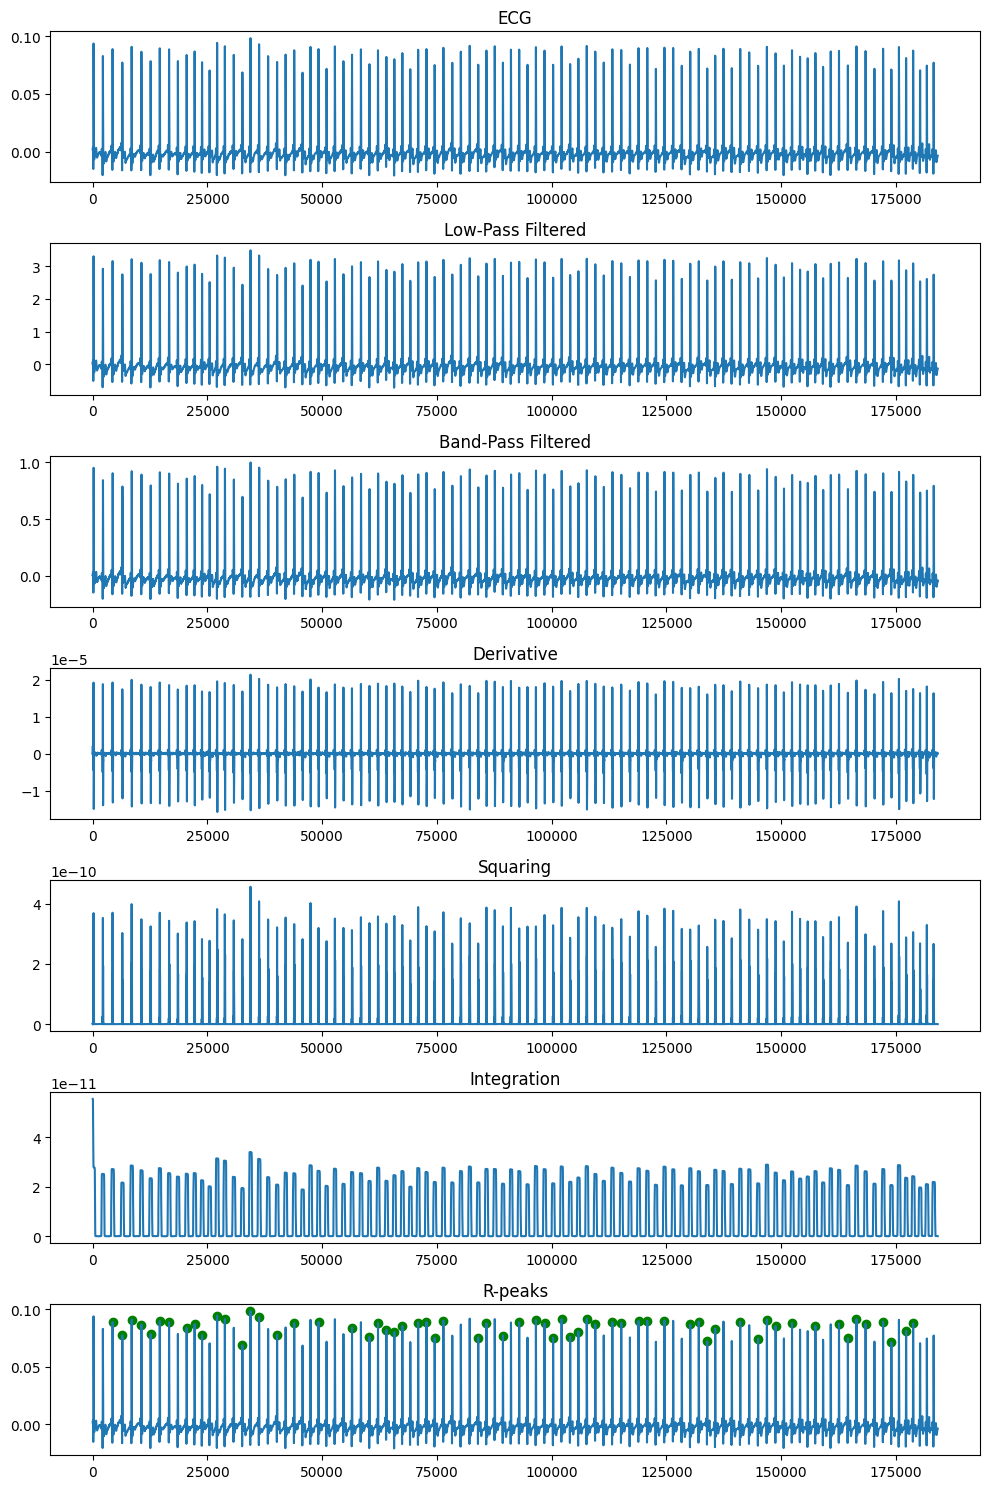

In [11]:
fig, axs = plt.subplots(7, 1, figsize=(10, 15))

axs[0].plot(ecg_signal)
axs[0].set_title('ECG')

axs[1].plot(lowpass_signal)
axs[1].set_title('Low-Pass Filtered')

axs[2].plot(bandpass_signal)
axs[2].set_title('Band-Pass Filtered')

axs[3].plot(derivative)
axs[3].set_title('Derivative')

axs[4].plot(squared_signal)
axs[4].set_title('Squaring')

axs[5].plot(integrated_signal)
axs[5].set_title('Integration')

axs[6].plot(ecg_signal)
axs[6].scatter(peaks,ecg_signal[peaks],color = "g",)
axs[6].set_title('R-peaks')

plt.tight_layout()
plt.show()



In [12]:
def extract_beat(signal, r_peak_index, beat_duration, sampling_rate):

    # Calculate the number of samples for the beat duration
    num_samples = int(beat_duration * sampling_rate)

    # Calculate the start and end indices of the beat window
    start_index = max(0, int(r_peak_index - num_samples / 2))
    end_index = min(len(signal), int(r_peak_index + num_samples / 2))
    
    # Extract the beat segment from the signal
    beat_segment = signal[start_index:end_index]
    return beat_segment

peak_idx    = 0
# Extract a beat from the BP signal
bp_beat     = extract_beat(BP, peaks[peak_idx], 1, fs)

# Extract a beat from the BCG signal
bcg_beat    = extract_beat(BCG, peaks[peak_idx], 1, fs)

# Extract a beat from the PPG signal
ppg_beat    = extract_beat(finger_PPG, peaks[peak_idx], 1, fs)

# Extract a beat from the ECG signal
ecg_beat    = extract_beat(ECG, peaks[peak_idx], 1, fs)

# Extract a beat from the systolic signal
sbp_beat    = extract_beat(systolic,  peaks[peak_idx],1, fs)
# Extract a beat from the diastolic signal
dbp_beat    = extract_beat(diastolic,  peaks[peak_idx],1, fs)


In [13]:

ppg_features        = PPG_Points(ppg_beat,peaks[peak_idx]+first_idx,fs)
max_idx, min_idx    = ppg_features.findMaxMin()

# Derivative period
derivative_period   = 0
# First Derivative
first_derivative    = ppg_beat.diff(periods=derivative_period)
# Second derivative
second_derivative   = first_derivative.diff(periods=derivative_period)
maxfirst            = first_derivative.idxmax()
maxsecond           = second_derivative.idxmax()

# Exponential moving average to suppress motion artifact
bcg_beat_exponential_ma = bcg_beat.ewm(alpha=1).mean()

# Extract BCG features
bcg_features    = BCG_Waves(bcg_beat_exponential_ma,peaks[peak_idx],fs)
idxI            = bcg_features.findIWave()
idxJ            = bcg_features.findJWave()
idxK            = bcg_features.findKWave()

# Extract BP features
bp_feature      = BP_Points(bp_beat,peaks[peak_idx]+first_idx,fs)
bp_max_idx      = bp_feature.findMax()
bp_min_idx      = bp_feature.findMin()


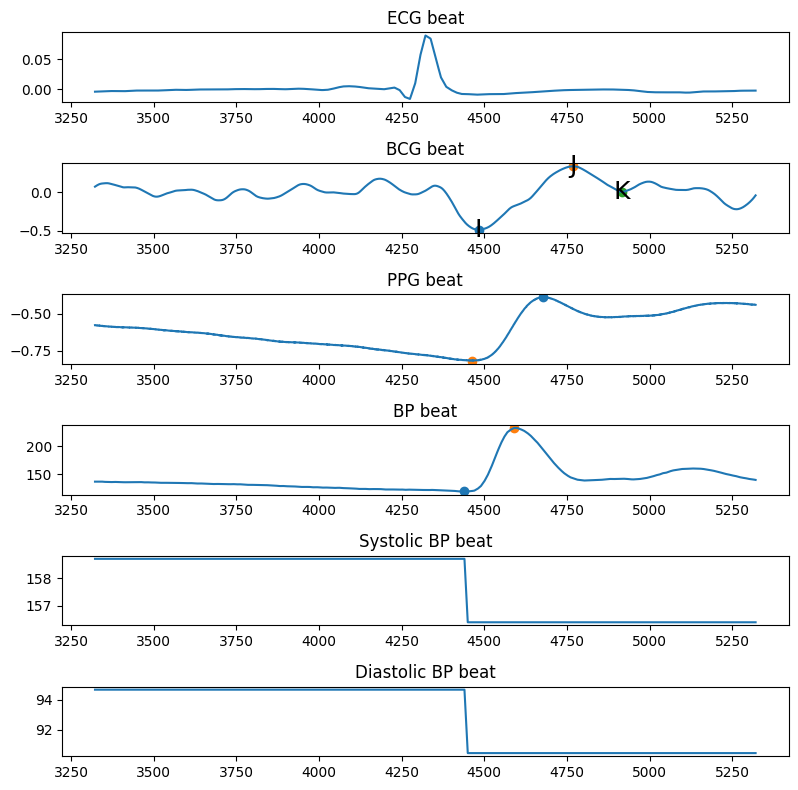

In [14]:
fig, axs = plt.subplots(6, 1, figsize=(8, 8))

axs[0].plot(ecg_beat)
axs[0].set_title('ECG beat')

axs[1].plot(bcg_beat_exponential_ma)
axs[1].scatter(idxI,bcg_beat_exponential_ma[idxI])
axs[1].text(idxI,bcg_beat_exponential_ma[idxI],'I',fontsize=18, ha='center', va='center')
axs[1].scatter(idxJ,bcg_beat_exponential_ma[idxJ])
axs[1].text(idxJ,bcg_beat_exponential_ma[idxJ],'J',fontsize=18, ha='center', va='center')
axs[1].scatter(idxK,bcg_beat_exponential_ma[idxK])
axs[1].text(idxK,bcg_beat_exponential_ma[idxK],'K',fontsize=18, ha='center', va='center')
axs[1].set_title('BCG beat')

axs[2].plot(ppg_beat)
axs[2].scatter(max_idx,ppg_beat[max_idx])
axs[2].scatter(min_idx,ppg_beat[min_idx])
axs[2].set_title('PPG beat')

axs[3].plot(bp_beat)
axs[3].scatter(bp_min_idx,bp_beat[bp_min_idx])
axs[3].scatter(bp_max_idx,bp_beat[bp_max_idx])
axs[3].set_title('BP beat')

axs[4].plot(sbp_beat)
axs[4].set_title('Systolic BP beat')

axs[5].plot(dbp_beat)
axs[5].set_title('Diastolic BP beat')

plt.tight_layout()
plt.show()




In [15]:
# PTT was defined as the time interval between the R-wave of the ECG and
# the peak of the PPG signal at the finger site within the same cardiac cycle.
peaks_ppg      = []
PTT_sys_ppg    = []
PTT_dia_ppg    = []
PTT1           = []
PTT4           = []
sbp_beats      = []
dbp_beats      = []

for peak_i in peaks:
    
    
    # Extract a beat from the ECG signal
    ecg_beat                = extract_beat(ECG, peak_i, 1, fs)
    # Extract a beat from the PPG signal
    ppg_beat                = extract_beat(finger_PPG, peak_i, 1, fs)
    ppg_peaks               = PPG_Points(ppg_beat,peak_i+first_idx,fs)
    max_idx, min_idx        = ppg_peaks.findMaxMin()
    peaks_ppg.append(max_idx)
    PTT_sys_ppg.append((max_idx - peak_i)/fs) # PTT related to systolic blood pressure
    PTT_dia_ppg.append((min_idx - peak_i)/fs) # PTT related to diastolic blood pressure

    # Calculate PPT1 and PTT4 in ref[Kim+15]
    # Extract a beat from the BP signal
    bp_beat                 = extract_beat(BP, peak_i, 1, fs)
    # Extract BP features
    bp_feature              = BP_Points(bp_beat,peak_i+first_idx,fs)
    max_bp                  = bp_feature.findMax()
    min_bp                  = bp_feature.findMin()

    # Extract a beat from the BCG signal
    bcg_beat                = extract_beat(BCG, peak_i, 1, fs)
    bcg_beat_exponential_ma = bcg_beat.ewm(alpha=1).mean()
    bcg_features            = BCG_Waves(bcg_beat_exponential_ma,peak_i,fs)
    idxI                    = bcg_features.findIWave()

    PTT1.append(abs(min_bp - idxI)/fs)
    PTT4.append(abs(max_bp - idxI)/fs)

    # Extract a beat from the systolic signal
    sbp_beat =  extract_beat(systolic,  peak_i,1, fs)
    sbp_beats.append(sbp_beat.to_list()[0])
    # Extract a beat from the diastolic signal
    dbp_beat = extract_beat(diastolic,  peak_i,1, fs)
    dbp_beats.append(dbp_beat.to_list()[0])
   

    



Text(0, 0.5, 'Time[sec]')

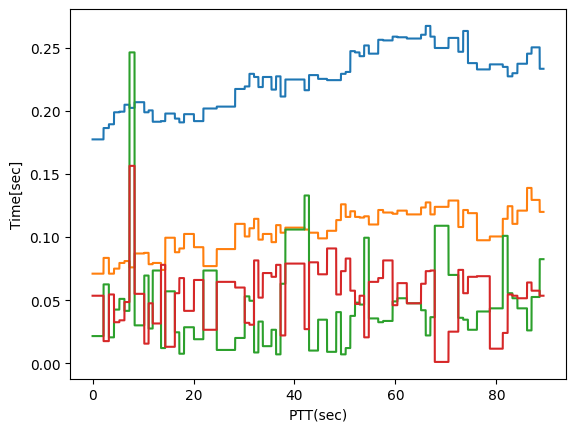

In [16]:

PTT_sys_ext     = []
PTT_dia_ext     = []
PTT1_ext        = []
PTT4_ext        = []
sbp_beats_ext   = []
dbp_beats_ext   = []
j = 0
total_dist = 0
for dist in RR:
    
    for i in range(dist-1):
        PTT_sys_ext.append(PTT_sys_ppg[j])
        PTT_dia_ext.append(PTT_dia_ppg[j])
        PTT1_ext.append(PTT1[j])
        PTT4_ext.append(PTT4[j])
       
        sbp_beats_ext.append(sbp_beats[j])
        dbp_beats_ext.append(dbp_beats[j])

    j = j + 1 

# Define the sample indices
sample_indices = np.arange(0, len(PTT_sys_ext))

# Convert sample indices to time values
t = sample_indices / fs

plt.plot(t,PTT_sys_ext)
plt.plot(t,PTT_dia_ext)
plt.plot(t,PTT1_ext)
plt.plot(t,PTT4_ext)
plt.xlabel("PTT(sec)")
plt.ylabel("Time[sec]")



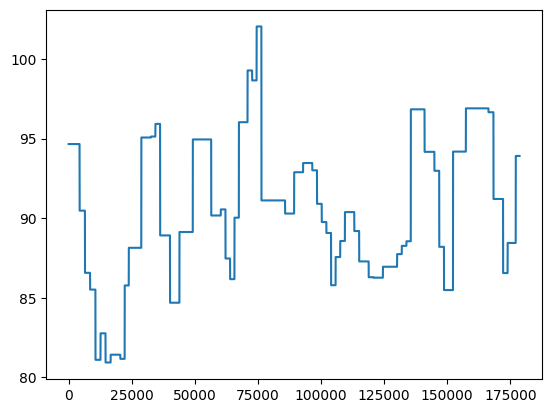

In [17]:
plt.plot(dbp_beats_ext)

In [18]:
X_sys = {
        'PTT_PPG_SYS': PTT_sys_ext,
        'PTT_BCG_SYS': PTT4_ext
        }
X_dia = {
        'PTT_PPG_DIA': PTT_dia_ext,
        'PTT_BCG_DIA': PTT1_ext
        }

y_dia = {
        'DIA': dbp_beats_ext,
        }

y_sys= {
        'SYS': sbp_beats_ext,
        }

# Create DataFrame
X_sys = pd.DataFrame(X_sys)
X_sys = X_sys[['PTT_PPG_SYS', 'PTT_BCG_SYS']]

X_dia = pd.DataFrame(X_dia)
X_dia = X_dia[['PTT_PPG_DIA', 'PTT_BCG_DIA']]

y_sys = pd.DataFrame(y_sys)
y_sys = y_sys['SYS']
y_dia = pd.DataFrame(y_dia)
y_dia = y_dia['DIA']



In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# Create an instance of the LinearRegression model
model_sb = LinearRegression()
model_db = LinearRegression()

X_train_sb, X_test_sb, y_train_sb, y_test_sb = train_test_split(X_sys, y_sys, test_size=0.2, random_state=42)
model_sb.fit(X_train_sb, y_train_sb)

X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(X_dia, y_dia, test_size=0.2, random_state=42)
model_db.fit(X_train_db, y_train_db)


predicted_sbp = model_sb.predict(X_test_sb)
predicted_dbp = model_db.predict(X_test_db)



In [20]:
correlation_coefficient_sbp = np.corrcoef(predicted_sbp, y_test_sb)[0, 1]
correlation_coefficient_dbp = np.corrcoef(predicted_dbp, y_test_db)[0, 1]

In [21]:
correlation_coefficient_sbp

0.6428657418357495

In [22]:
correlation_coefficient_dbp

0.12406138082002219